In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import shutil
from shutil import copy
from collections import defaultdict
import tensorflow as tf
import keras.backend as K
from patchify import patchify, unpatchify
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [2]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [3]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor,mask_type):

    for image_path in glob.glob(f'Images for model/{mask_type}/{dataset_type}_images/{dataset_type}/*.png'):
        mask_suffix = f'_{mask_type}_mask.tif'
        path = f'Images for model/{mask_type}'
        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)

        image = cv2.imread(image_path)
        image = padder(image, patch_size)
        if scaling_factor != 1:
            image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        image_patch_path = image_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            image_patch_path_numbered = f'{image_patch_path[:-4]}_{i}.png'
            cv2.imwrite(image_patch_path_numbered, patch)

        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)
        mask = cv2.imread(mask_path, 0)
        mask = padder(mask, patch_size)
        if scaling_factor != 1:
            mask = cv2.resize(mask, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(mask, (patch_size, patch_size), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        mask_patch_path = mask_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            mask_patch_path_numbered = f'{mask_patch_path[:-4]}_{i}.png'
            cv2.imwrite(mask_patch_path_numbered, patch)

----

Modeling

In [4]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        y_pred = tf.cast(y_pred>0.5,y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [5]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, lr):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(lr=lr) 
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1, iou])
    model.summary()
    
    return model

In [6]:
patch_size = 128
scaling_factor = 1


Training model for roots

In [7]:
mask_type = 'root'

In [8]:
patch_dir = 'Images for model/root_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val','test_images/test','test_masks/test']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [9]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('test', patch_size, scaling_factor, mask_type= mask_type)

In [10]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# val masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

# test images

test_image_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(
    f'{patch_dir}/test_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# test masks
test_mask_datagen = ImageDataGenerator()

test_mask_generator = test_mask_datagen.flow_from_directory(
    f'{patch_dir}/test_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

test_generator = zip(test_image_generator, test_mask_generator)


Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 21384 images belonging to 1 classes.
Found 21384 images belonging to 1 classes.


In [11]:
from keras.callbacks import EarlyStopping
model_root = simple_unet_model(patch_size, patch_size, 1, lr=0.001)

cb = EarlyStopping(monitor='val_iou',
                   patience=3   ,
                   restore_best_weights='True',
                   mode='max')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
h_root = model_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/50
1980/1980 [==============================] - 125s 59ms/step - loss: 0.0250 - accuracy: 0.9942 - f1: 0.2051 - iou: 0.8269 - val_loss: 0.0069 - val_accuracy: 0.9981 - val_f1: 0.3647 - val_iou: 0.8417
Epoch 2/50
1980/1980 [==============================] - 116s 59ms/step - loss: 0.0090 - accuracy: 0.9969 - f1: 0.5595 - iou: 0.8625 - val_loss: 0.0034 - val_accuracy: 0.9988 - val_f1: 0.4378 - val_iou: 0.9368
Epoch 3/50
1980/1980 [==============================] - 116s 59ms/step - loss: 0.0094 - accuracy: 0.9972 - f1: 0.5883 - iou: 0.8864 - val_loss: 0.0133 - val_accuracy: 0.9974 - val_f1: 0.0000e+00 - val_iou: 0.9364
Epoch 4/50
1980/1980 [==============================] - 116s 59ms/step - loss: 0.0107 - accuracy: 0.9966 - f1: 0.5050 - iou: 0.8501 - val_loss: 0.0030 - val_accuracy: 0.9989 - val_f1: 0.4696 - val_iou: 0.9395
Epoch 5/50
1980/1980 [==============================] - 116s 59ms/step - loss: 0.0066 - accuracy: 0.9975 - f1: 0.6170 - iou: 0.9041 - val_loss: 0.0035 - val_acc

In [13]:
evaluation = model_root.evaluate(test_generator, steps=val_image_generator.samples//16)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])
print("Evaluation F1 Score:", evaluation[2])
print("Evaluation IOU:", evaluation[3])


495/495 [==============================] - 9s 18ms/step - loss: 0.0044 - accuracy: 0.9984 - f1: 0.5704 - iou: 0.9505
Evaluation Loss: 0.004436336923390627
Evaluation Accuracy: 0.9983607530593872
Evaluation F1 Score: 0.5703803896903992
Evaluation IOU: 0.9504580497741699


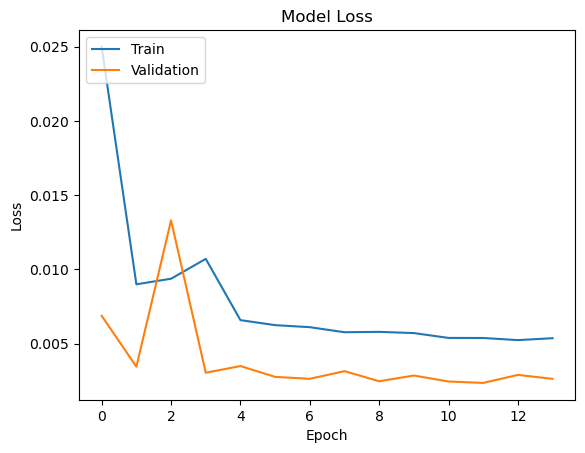

In [14]:
# Plotting learning curves
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(h_root.history['loss'])
plt.plot(h_root.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
input_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\test'
output_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\predicted_masks\predicted_masks_root'


os.makedirs(output_dir, exist_ok=True)

image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Loop through each image file
for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    
    # Read the image
    image = cv2.imread(image_path)
    image = padder(image, patch_size)
    
    patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
    
    i = patches.shape[0]
    j = patches.shape[1]
    
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    patches.shape
    
    preds = model_root.predict(patches/255)
    
    preds = preds.reshape(i, j, 128, 128)
    
    predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
    
    # # Apply thresholding to the predicted mask
    # threshold = 0.5  
    # predicted_mask = (predicted_mask > threshold).astype(np.uint8)
    
    
    output_filename = image_file.replace('.png', '_root_mask_predicted.png')
    output_file = os.path.join(output_dir, output_filename)
    cv2.imwrite(output_file, predicted_mask * 255)  



25/25 [==============================] - 1s 34ms/step


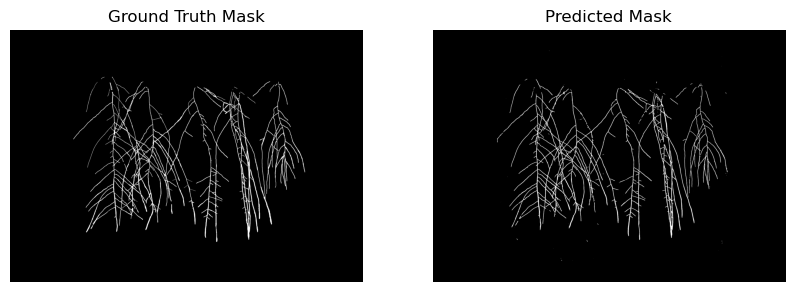

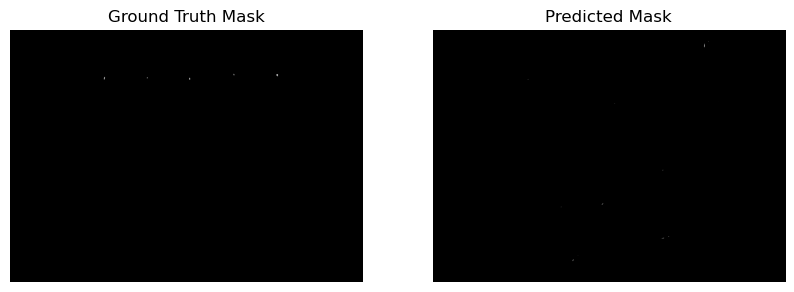

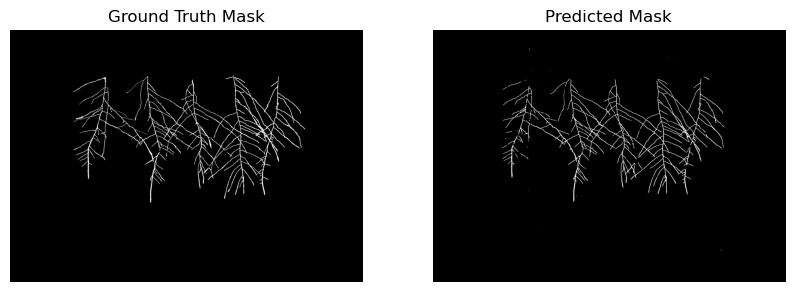

In [16]:
predicted_masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\predicted_masks\predicted_masks_root'
ground_truth_masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\splited_masks\root'


predicted_mask_files = os.listdir(predicted_masks_dir)

num_visualizations = 3


for predicted_mask_file in predicted_mask_files[:num_visualizations]:
    predicted_mask_path = os.path.join(predicted_masks_dir, predicted_mask_file)
    
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)
    ground_truth_mask_path = os.path.join(ground_truth_masks_dir, predicted_mask_file.replace('_root_mask_predicted.png', '_root_mask.tif'))
    
    
    if os.path.exists(ground_truth_mask_path):
        ground_truth_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
        
        width = min(predicted_mask.shape[1], ground_truth_mask.shape[1])
        height = min(predicted_mask.shape[0], ground_truth_mask.shape[0])
        predicted_mask = cv2.resize(predicted_mask, (width, height))
        ground_truth_mask = cv2.resize(ground_truth_mask, (width, height))
        
        # Threshold predicted mask 
        _, predicted_mask = cv2.threshold(predicted_mask, 80, 255, cv2.THRESH_BINARY)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(ground_truth_mask, cmap='gray')
        axes[0].set_title('Ground Truth Mask')
        axes[0].axis('off')
        
        axes[1].imshow(predicted_mask, cmap='gray')
        axes[1].set_title('Predicted Mask')
        axes[1].axis('off')
        
        plt.show()
    else:
        print(f"No ground truth mask found for {predicted_mask_file}")


25/25 [==============================] - 1s 30ms/step


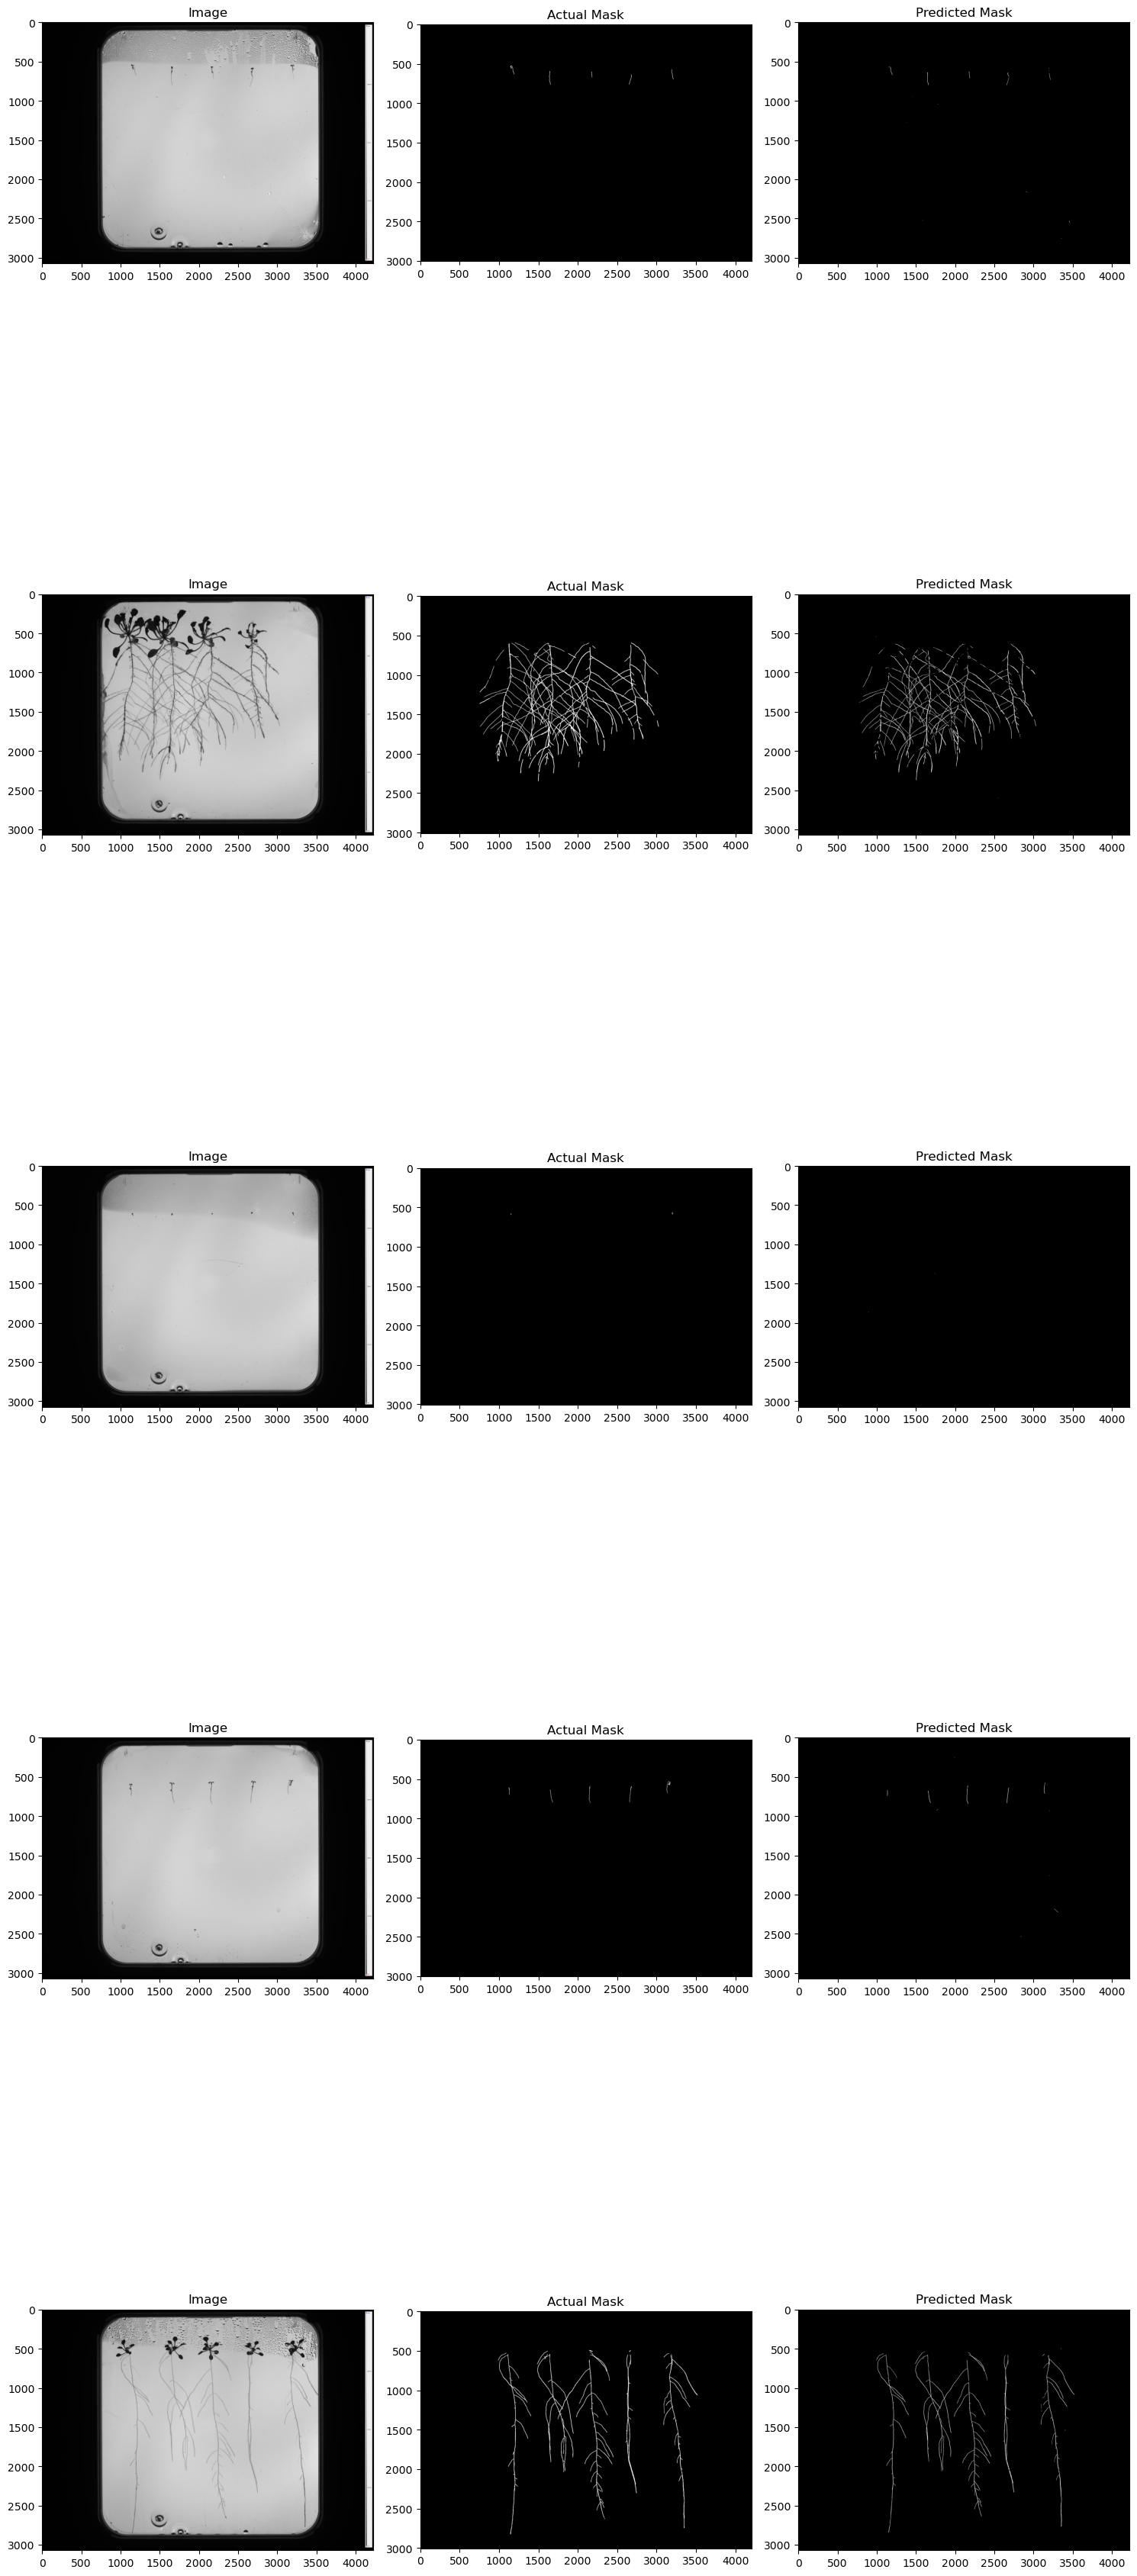

In [17]:

def visualize_predictions(model, image_paths, mask_paths, patch_size=128):
    fig, axs = plt.subplots(len(image_paths), 3, figsize=(15, 8 * len(image_paths)))

    for idx, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = cv2.imread(image_path)
        image = padder(image, patch_size) 

        patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
        i, j = patches.shape[0], patches.shape[1]
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        preds = model_root.predict(patches / 255)
        preds = preds.reshape(i, j, 128, 128)

        predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))

        axs[idx, 0].imshow(image)
        axs[idx, 0].set_title('Image')

        mask = cv2.imread(mask_path, 0)  
        axs[idx, 1].imshow(mask, cmap='gray')
        axs[idx, 1].set_title('Actual Mask')

        axs[idx, 2].imshow(predicted_mask > 0.6, cmap='gray')  # Adjust threshold if needed
        axs[idx, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()


mask_paths = [
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_root_mask.tif',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected_root_mask.tif',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\005_43-2-ROOT1-2023-08-08_control_pH7_-Fe+B_col0_04-Fish Eye Corrected_root_mask.tif',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\006_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected_root_mask.tif',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\images for model\root\train_masks\train\006_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_02-Fish Eye Corrected_root_mask.tif'
]


image_paths = [
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected.png',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected.png',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\005_43-2-ROOT1-2023-08-08_control_pH7_-Fe+B_col0_04-Fish Eye Corrected.png',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\006_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected.png',
    r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\train\006_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_02-Fish Eye Corrected.png'
]

visualize_predictions(model_root, image_paths, mask_paths)


Training model for shoots

In [18]:
mask_type = 'shoot'

In [19]:
patch_dir = 'Images for model/shoot_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val','test_images/test','test_masks/test']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)


In [20]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('test', patch_size, scaling_factor, mask_type= mask_type)

In [21]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# val masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

# test images

test_image_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(
    f'{patch_dir}/test_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# test masks
test_mask_datagen = ImageDataGenerator()

test_mask_generator = test_mask_datagen.flow_from_directory(
    f'{patch_dir}/test_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

test_generator = zip(test_image_generator, test_mask_generator)


Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 21384 images belonging to 1 classes.
Found 21384 images belonging to 1 classes.


In [22]:
from keras.callbacks import EarlyStopping
model_shoot = simple_unet_model(patch_size, patch_size, 1, lr=0.0001)

cb = EarlyStopping(monitor='val_iou',
                   patience=8,
                   restore_best_weights='True',
                   mode='max')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [23]:
h_shoot = model_shoot.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/50
1980/1980 [==============================] - 119s 59ms/step - loss: 0.0290 - accuracy: 0.9921 - f1: 0.0061 - iou: 0.7726 - val_loss: 0.0064 - val_accuracy: 0.9977 - val_f1: 0.0713 - val_iou: 0.9588
Epoch 2/50
1980/1980 [==============================] - 117s 59ms/step - loss: 0.0092 - accuracy: 0.9961 - f1: 0.1780 - iou: 0.9367 - val_loss: 0.0057 - val_accuracy: 0.9978 - val_f1: 0.0682 - val_iou: 0.9651
Epoch 3/50
1980/1980 [==============================] - 118s 59ms/step - loss: 0.0071 - accuracy: 0.9970 - f1: 0.2329 - iou: 0.9497 - val_loss: 0.0051 - val_accuracy: 0.9978 - val_f1: 0.0676 - val_iou: 0.9671
Epoch 4/50
1980/1980 [==============================] - 118s 60ms/step - loss: 0.0059 - accuracy: 0.9976 - f1: 0.2450 - iou: 0.9573 - val_loss: 0.0042 - val_accuracy: 0.9984 - val_f1: 0.1425 - val_iou: 0.9688
Epoch 5/50
1980/1980 [==============================] - 118s 60ms/step - loss: 0.0050 - accuracy: 0.9980 - f1: 0.2607 - iou: 0.9628 - val_loss: 0.0042 - val_accurac

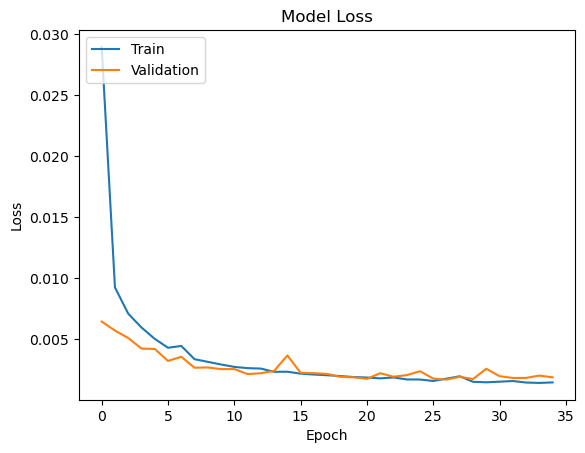

In [24]:
# Plotting learning curves
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(h_shoot.history['loss'])
plt.plot(h_shoot.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
evaluation = model_shoot.evaluate(test_generator, steps=val_image_generator.samples//16)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])
print("Evaluation F1 Score:", evaluation[2])
print("Evaluation IOU:", evaluation[3])

  4/495 [..............................] - ETA: 8s - loss: 8.2783e-04 - accuracy: 0.9997 - f1: 0.2340 - iou: 0.9825     

495/495 [==============================] - 9s 18ms/step - loss: 0.0025 - accuracy: 0.9991 - f1: 0.2891 - iou: 0.9823
Evaluation Loss: 0.002512518083676696
Evaluation Accuracy: 0.9991373419761658
Evaluation F1 Score: 0.2890911400318146
Evaluation IOU: 0.9822964668273926


In [26]:
input_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\test'
output_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\predicted_masks\predicted_masks_shoot'


os.makedirs(output_dir, exist_ok=True)

image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Loop through each image file
for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    
    # Read the image
    image = cv2.imread(image_path)
    image = padder(image, patch_size)
    
    patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
    
    i = patches.shape[0]
    j = patches.shape[1]
    
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    patches.shape
    
    preds = model_shoot.predict(patches/255)
    
    preds = preds.reshape(i, j, 128, 128)
    
    predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
    
    # # Apply thresholding to the predicted mask
    # threshold = 0.5  
    # predicted_mask = (predicted_mask > threshold).astype(np.uint8)
    
    
    output_filename = image_file.replace('.png', '_shoot_mask_predicted.png')
    output_file = os.path.join(output_dir, output_filename)
    cv2.imwrite(output_file, predicted_mask * 255)  



25/25 [==============================] - 1s 30ms/step


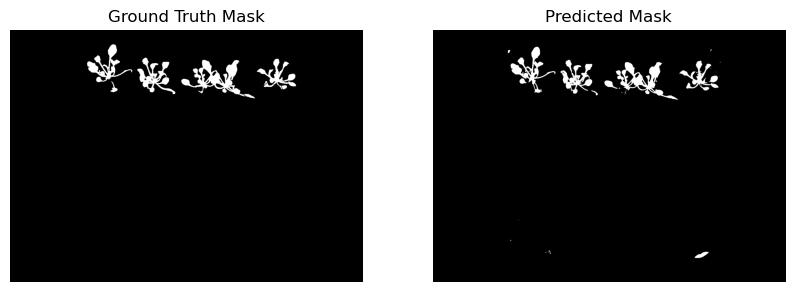

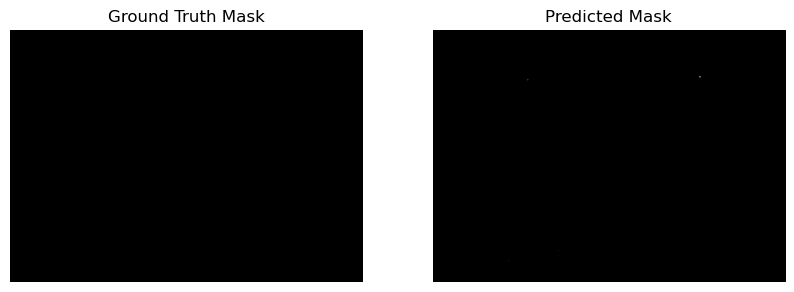

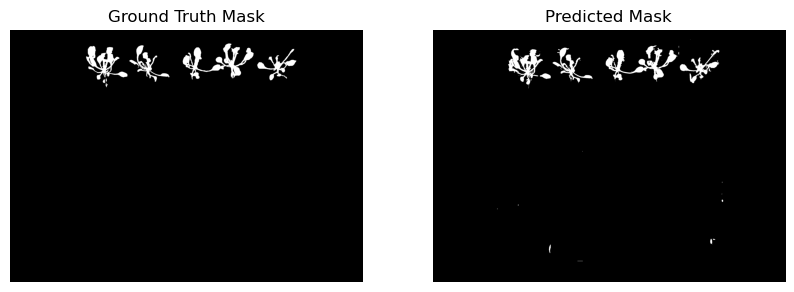

In [27]:

predicted_masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\predicted_masks\predicted_masks_shoot'
ground_truth_masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\splited_masks\shoot'

predicted_mask_files = os.listdir(predicted_masks_dir)

num_visualizations = 3


for predicted_mask_file in predicted_mask_files[:num_visualizations]:
    predicted_mask_path = os.path.join(predicted_masks_dir, predicted_mask_file)
    
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)
    ground_truth_mask_path = os.path.join(ground_truth_masks_dir, predicted_mask_file.replace('_shoot_mask_predicted.png', '_shoot_mask.tif'))
    
    
    if os.path.exists(ground_truth_mask_path):
        ground_truth_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
        
        width = min(predicted_mask.shape[1], ground_truth_mask.shape[1])
        height = min(predicted_mask.shape[0], ground_truth_mask.shape[0])
        predicted_mask = cv2.resize(predicted_mask, (width, height))
        ground_truth_mask = cv2.resize(ground_truth_mask, (width, height))
        
        # Threshold predicted mask 
        _, predicted_mask = cv2.threshold(predicted_mask, 50, 255, cv2.THRESH_BINARY)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(ground_truth_mask, cmap='gray')
        axes[0].set_title('Ground Truth Mask')
        axes[0].axis('off')
        
        axes[1].imshow(predicted_mask, cmap='gray')
        axes[1].set_title('Predicted Mask')
        axes[1].axis('off')
        
        plt.show()
    else:
        print(f"No ground truth mask found for {predicted_mask_file}")


Training model for seeds

In [28]:
mask_type = 'seed'


In [29]:
patch_dir = 'Images for model/seed_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val','test_images/test','test_masks/test']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [30]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('test', patch_size, scaling_factor, mask_type= mask_type)

In [31]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# val masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

# test images

test_image_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(
    f'{patch_dir}/test_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# test masks
test_mask_datagen = ImageDataGenerator()

test_mask_generator = test_mask_datagen.flow_from_directory(
    f'{patch_dir}/test_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

test_generator = zip(test_image_generator, test_mask_generator)


Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 21384 images belonging to 1 classes.
Found 21384 images belonging to 1 classes.


In [32]:
from keras.callbacks import EarlyStopping
model_seed = simple_unet_model(patch_size, patch_size, 1, lr=0.0001)

cb = EarlyStopping(monitor='val_iou',
                   patience=8,
                   restore_best_weights='True',
                   mode='max')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

In [33]:
h_seed = model_seed.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

Epoch 1/50
1980/1980 [==============================] - 119s 59ms/step - loss: 0.0075 - accuracy: 0.9976 - f1: 3.7390e-07 - iou: 0.8495 - val_loss: 0.0019 - val_accuracy: 1.0000 - val_f1: 0.0000e+00 - val_iou: 0.9931
Epoch 2/50
1980/1980 [==============================] - 118s 59ms/step - loss: 5.8639e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9915 - val_loss: 6.5136e-04 - val_accuracy: 1.0000 - val_f1: 0.0000e+00 - val_iou: 0.9931
Epoch 3/50
1980/1980 [==============================] - 118s 60ms/step - loss: 5.9353e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9928 - val_loss: 6.1143e-04 - val_accuracy: 1.0000 - val_f1: 0.0000e+00 - val_iou: 0.9931
Epoch 4/50
1980/1980 [==============================] - 118s 60ms/step - loss: 5.0446e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9937 - val_loss: 3.9471e-04 - val_accuracy: 1.0000 - val_f1: 0.0000e+00 - val_iou: 0.9931
Epoch 5/50
1980/1980 [==============================] - 118s 60ms/step - loss: 4.8567e-04 - accuracy: 0.9999

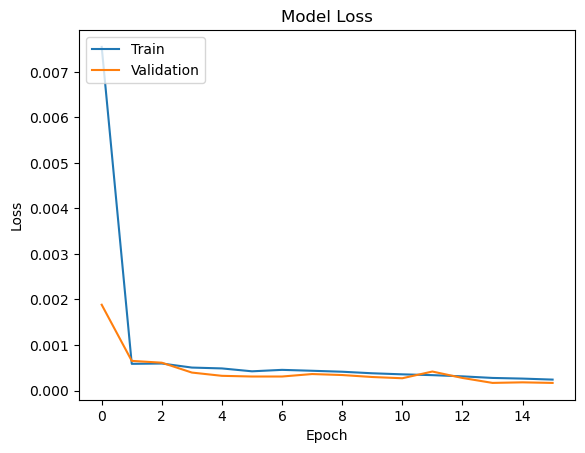

In [34]:
# Plotting learning curves
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(h_seed.history['loss'])
plt.plot(h_seed.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
evaluation = model_seed.evaluate(test_generator, steps=val_image_generator.samples//16)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])
print("Evaluation F1 Score:", evaluation[2])
print("Evaluation IOU:", evaluation[3])

495/495 [==============================] - 9s 18ms/step - loss: 4.0821e-04 - accuracy: 1.0000 - f1: 0.0000e+00 - iou: 0.9939
Evaluation Loss: 0.00040820802678354084
Evaluation Accuracy: 0.9999513626098633
Evaluation F1 Score: 0.0
Evaluation IOU: 0.9939393997192383


In [36]:
input_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\test'
output_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\predicted_masks\predicted_masks_seed'


os.makedirs(output_dir, exist_ok=True)

image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Loop through each image file
for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    
    # Read the image
    image = cv2.imread(image_path)
    image = padder(image, patch_size)
    
    patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
    
    i = patches.shape[0]
    j = patches.shape[1]
    
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    patches.shape
    
    preds = model_seed.predict(patches/255)
    
    preds = preds.reshape(i, j, 128, 128)
    
    predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
    
    # # Apply thresholding to the predicted mask
    # threshold = 0.5  
    # predicted_mask = (predicted_mask > threshold).astype(np.uint8)
    
    
    output_filename = image_file.replace('.png', '_seed_mask_predicted.png')
    output_file = os.path.join(output_dir, output_filename)
    cv2.imwrite(output_file, predicted_mask * 255)  



25/25 [==============================] - 1s 30ms/step


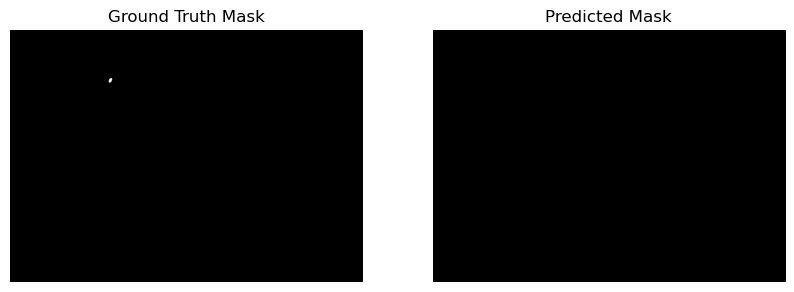

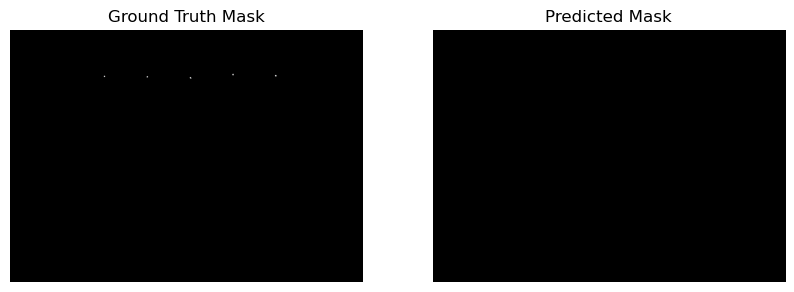

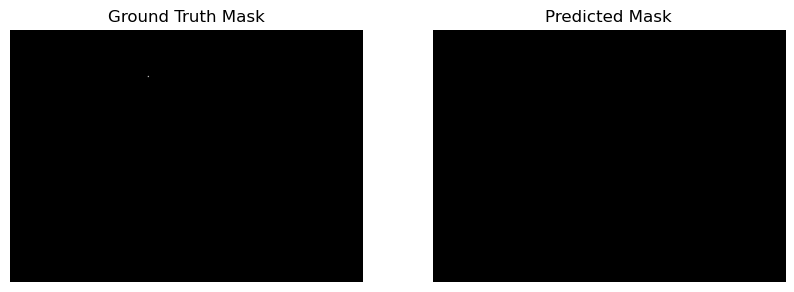

In [37]:

predicted_masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\predicted_masks\predicted_masks_seed'
ground_truth_masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\splited_masks\seed'

predicted_mask_files = os.listdir(predicted_masks_dir)

num_visualizations = 3


for predicted_mask_file in predicted_mask_files[:num_visualizations]:
    predicted_mask_path = os.path.join(predicted_masks_dir, predicted_mask_file)
    
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)
    ground_truth_mask_path = os.path.join(ground_truth_masks_dir, predicted_mask_file.replace('_seed_mask_predicted.png', '_seed_mask.tif'))
    
    
    if os.path.exists(ground_truth_mask_path):
        ground_truth_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
        
        width = min(predicted_mask.shape[1], ground_truth_mask.shape[1])
        height = min(predicted_mask.shape[0], ground_truth_mask.shape[0])
        predicted_mask = cv2.resize(predicted_mask, (width, height))
        ground_truth_mask = cv2.resize(ground_truth_mask, (width, height))
        
        # Threshold predicted mask 
        _, predicted_mask = cv2.threshold(predicted_mask, 50, 255, cv2.THRESH_BINARY)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(ground_truth_mask, cmap='gray')
        axes[0].set_title('Ground Truth Mask')
        axes[0].axis('off')
        
        axes[1].imshow(predicted_mask, cmap='gray')
        axes[1].set_title('Predicted Mask')
        axes[1].axis('off')
        
        plt.show()
    else:
        print(f"No ground truth mask found for {predicted_mask_file}")


Training model for occluded_roots

In [49]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor, mask_type):
    for image_path in glob.glob(f'Images for model/{mask_type}/{dataset_type}_images/{dataset_type}/*.png'):
        mask_suffix = f'_{mask_type}_mask.tif'
        path = f'Images for model/{mask_type}'
        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)

        image = cv2.imread(image_path)
        image = padder(image, patch_size)
        if scaling_factor != 1:
            image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        image_patch_path = image_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            image_patch_path_numbered = f'{image_patch_path[:-4]}_{i}.png'
            cv2.imwrite(image_patch_path_numbered, patch)

        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)
        mask = cv2.imread(mask_path, 0)
        mask = padder(mask, patch_size)
        if scaling_factor != 1:
            mask = cv2.resize(mask, (0, 0), fx=scaling_factor, fy=scaling_factor)
        
        # Flatten the mask
        mask_flat = mask.flatten()

        patches = patchify(mask_flat, (patch_size * patch_size,), step=patch_size * patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        mask_patch_path = mask_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            mask_patch_path_numbered = f'{mask_patch_path[:-4]}_{i}.png'
            cv2.imwrite(mask_patch_path_numbered, patch)


In [50]:
mask_type = 'occluded_root'

In [51]:
patch_dir = 'Images for model/occluded_root_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val','test_images/test','test_masks/test']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [52]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('test', patch_size, scaling_factor, mask_type= mask_type)

In [53]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# val masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

# test images

test_image_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(
    f'{patch_dir}/test_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# test masks
test_mask_datagen = ImageDataGenerator()

test_mask_generator = test_mask_datagen.flow_from_directory(
    f'{patch_dir}/test_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

test_generator = zip(test_image_generator, test_mask_generator)

Found 31680 images belonging to 1 classes.
Found 29604 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 21384 images belonging to 1 classes.
Found 21384 images belonging to 1 classes.


In [54]:
from keras.callbacks import EarlyStopping
model_occluded_root = simple_unet_model(patch_size, patch_size, 1, lr=0.001)

cb = EarlyStopping(monitor='val_iou',
                   patience=3,
                   restore_best_weights='True',
                   mode='max')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_36 (Dropout)           (None, 128, 128, 16  0           ['conv2d_76[0][0]']              
                                )                                                           

c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [66]:
h = model_occluded_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=50,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16,
    callbacks=[cb]
)

In [67]:
evaluation = model_occluded_root.evaluate(test_generator, steps=val_image_generator.samples//16)

print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])
print("Evaluation F1 Score:", evaluation[2])
print("Evaluation IOU:", evaluation[3])


495/495 [==============================] - 12s 23ms/step - loss: 6.7462e-04 - accuracy: 0.9999 - f1: 0.0000e+00 - iou: 0.9816
Evaluation Loss: 0.0006746235303580761
Evaluation Accuracy: 0.9999420642852783
Evaluation F1 Score: 0.0
Evaluation IOU: 0.9815656542778015


In [70]:
input_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\Images\test'
output_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\predicted_masks\predicted_masks_occluded_root'


os.makedirs(output_dir, exist_ok=True)

image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Loop through each image file
for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    
    # Read the image
    image = cv2.imread(image_path)
    image = padder(image, patch_size)
    
    patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
    
    i = patches.shape[0]
    j = patches.shape[1]
    
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    patches.shape
    
    preds = model_occluded_root.predict(patches/255)
    
    preds = preds.reshape(i, j, 128, 128)
    
    predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
    
    # Apply thresholding to the predicted mask
    threshold = 0.5  
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)
    
    
    output_filename = image_file.replace('.png', '_occluded_root_mask_predicted.png')
    output_file = os.path.join(output_dir, output_filename)
    cv2.imwrite(output_file, predicted_mask_binary * 255)  



25/25 [==============================] - 1s 30ms/step


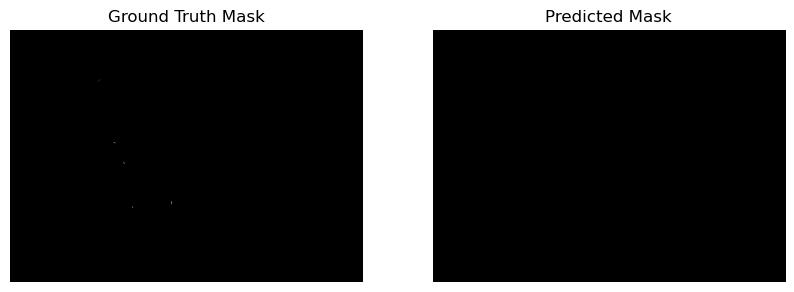

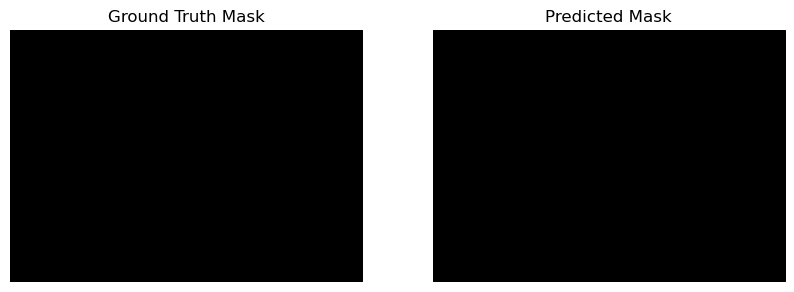

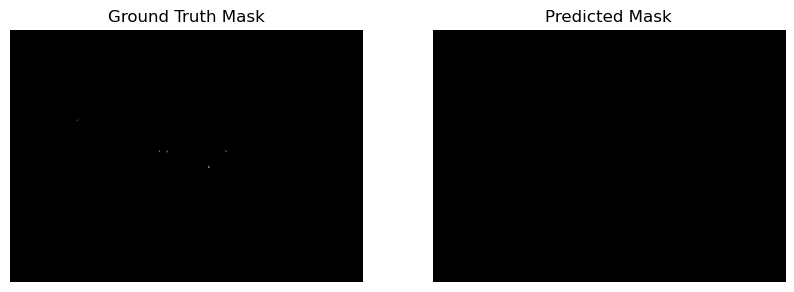

In [71]:
predicted_masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\predicted_masks\predicted_masks_occluded_root'
ground_truth_masks_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task4\splited_masks\occluded_root'


predicted_mask_files = os.listdir(predicted_masks_dir)

num_visualizations = 3


for predicted_mask_file in predicted_mask_files[:num_visualizations]:
    predicted_mask_path = os.path.join(predicted_masks_dir, predicted_mask_file)
    
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)
    ground_truth_mask_path = os.path.join(ground_truth_masks_dir, predicted_mask_file.replace('_root_mask_predicted.png', '_root_mask.tif'))
    
    
    if os.path.exists(ground_truth_mask_path):
        ground_truth_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
        
        width = min(predicted_mask.shape[1], ground_truth_mask.shape[1])
        height = min(predicted_mask.shape[0], ground_truth_mask.shape[0])
        predicted_mask = cv2.resize(predicted_mask, (width, height))
        ground_truth_mask = cv2.resize(ground_truth_mask, (width, height))
        
        # Threshold predicted mask 
        _, predicted_mask = cv2.threshold(predicted_mask, 127, 255, cv2.THRESH_BINARY)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(ground_truth_mask, cmap='gray')
        axes[0].set_title('Ground Truth Mask')
        axes[0].axis('off')
        
        axes[1].imshow(predicted_mask, cmap='gray')
        axes[1].set_title('Predicted Mask')
        axes[1].axis('off')
        
        plt.show()
    else:
        print(f"No ground truth mask found for {predicted_mask_file}")


---
